## About: This was originally a competition hosted on kaggle.com consisting of a classification problem in computer vision.

1. Problem statement: Given the dataset consisting of driver images in car and corresponding labels for 10 nos. categories (e.g. safe driving, texting, talking etc.), your task is to build a classification model to predict the category for that image

2. Dataset link: After creating an account on Kaggle, go to this competition page (https://www.kaggle.com/c/state-farm-distracted-driver-detection) and Join Competition. After joining the competition, you can either download the data on your local machine or you can use Kaggle kernel (like jupyter notebook) to build and train your model (recommended as it provides you with GPU computing to train your neural network and no need to download the dataset locally).

After creating an account on Kaggle, Download your Kaggle API key->(.json file), you do this by going to your kaggle account page and clicking 'Creat New API token'bold text

After downloading Kaggle API key->(.json file) go to left hand side and clicking files, and upload Kaggle API key->(.json file) which you have downloaded

I am using Google Colab, First we need to select GPU, go to Runtime->change runtime type->select GPU

In [1]:
# install kaggle python library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# After uploading kaggle.json file run this cell
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# !cp kaggle.json ~/.kaggle/

Now we need to download dataset, go to kaggle dataset link which has provided in project, clicking on Data-> Copy API command to clipboard


In [4]:
! kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [03:07<00:00, 22.4MB/s]
100% 4.00G/4.00G [03:07<00:00, 22.9MB/s]


In [5]:
# check left hand side file state-farm-distracted-driver-detection.zip, zip file has been downloaded
# now, we need to unzip this file
import zipfile
# copy dataset file path
zip_ref = zipfile.ZipFile("/content/state-farm-distracted-driver-detection.zip", "r")
zip_ref.extractall('/content')
zip_ref.close()

after unzip we have imgs folder, driver_imgs_list.csv, sample_submission.csv,
imgs folder-> content train folder(drivers images with respect to their classes), and 
test folder (driver images to predict)

In [40]:
# importing all packeges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import plot_model

In [7]:
# make train and test directory
train_directory = "/content/imgs/train/"
test_directory = "/content/imgs/"

### Create Train and validation data

In [8]:
# create a master directory which have training and validation data
os.mkdir('master_data')
os.mkdir('master_data/training')
os.mkdir('master_data/validation')

In [9]:
# read driver_imgs_list.csv file
data = pd.read_csv("/content/driver_imgs_list.csv", usecols = [1,2])
data.head()

,classname,img
0,c0,img_44733.jpg
1,c0,img_72999.jpg
2,c0,img_25094.jpg
3,c0,img_69092.jpg
4,c0,img_92629.jpg


In [10]:
data.values

array([['c0', 'img_44733.jpg'],
       ['c0', 'img_72999.jpg'],
       ['c0', 'img_25094.jpg'],
       ...,
       ['c9', 'img_25946.jpg'],
       ['c9', 'img_67850.jpg'],
       ['c9', 'img_9684.jpg']], dtype=object)

In [11]:
# all unique classes
classes_list = data['classname'].unique()
classes_list

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

In [43]:
classes = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

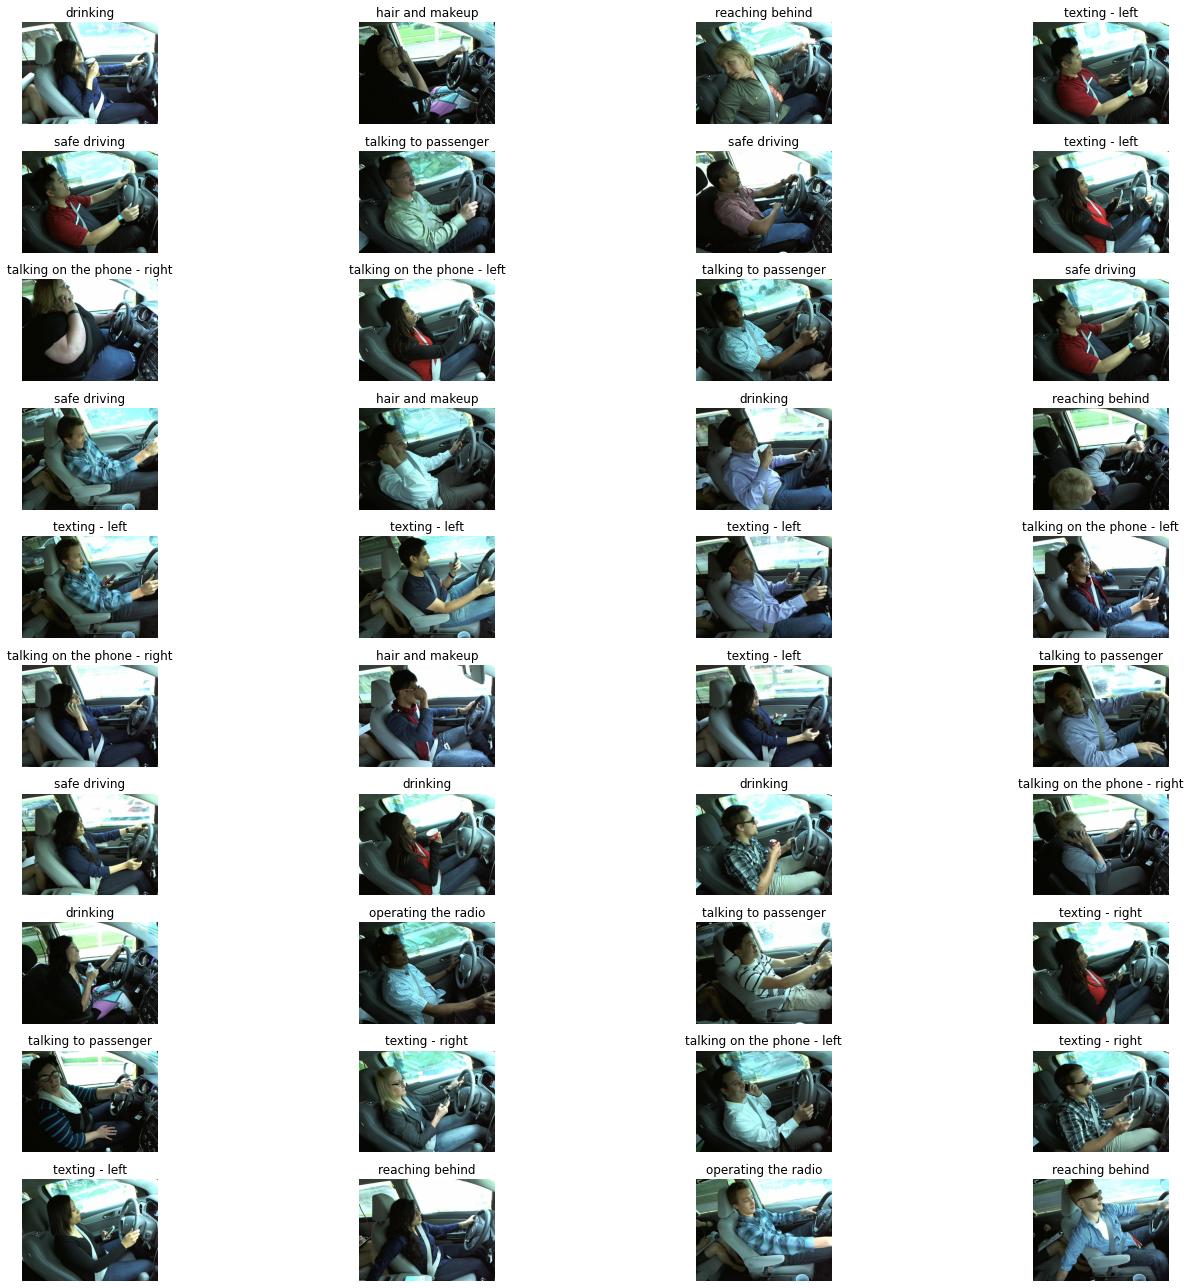

In [56]:
#plot randomly select image in each classes
fig = plt.figure(figsize = (20,18))
for i in range(1,41):
  img_indx = random.randint(0, data.shape[0])
  image = Image.open(os.path.join('/content/imgs/train/')+str(data.loc[img_indx, 'classname']+'/')+str(data.loc[img_indx, 'img']))  

  fig.add_subplot(10,4,i)
  plt.imshow(image)
  plt.title(classes[data.loc[img_indx, 'classname']])
  plt.axis('off')
  
plt.tight_layout()
plt.show()

In [12]:
# create make all classes dir in training and validation
for cls in classes_list:
  os.mkdir(os.path.join('master_data/training/', cls))
  os.mkdir(os.path.join('master_data/validation/', cls))

In [13]:
# make a dict which has key-> classes and values-> images with respected to their class
data_dict = {}
for cls, image in data.values:
  key = cls
  if key in data_dict:
    data_dict[key].append(image)
  else:
    data_dict[key] = [image]


In [14]:
for key in data_dict:
  # print classes and corresponding their images count
  print(key, " -> ", len(data_dict[key]))

c0  ->  2489
c1  ->  2267
c2  ->  2317
c3  ->  2346
c4  ->  2326
c5  ->  2312
c6  ->  2325
c7  ->  2002
c8  ->  1911
c9  ->  2129


In [15]:
from shutil import copyfile
import random

split_size = 0.8
for cls, image in data_dict.items():
  train_size = int(split_size*len(image))
  random.shuffle(image)
  train_image = image[:train_size]
  validation_image = image[train_size:]
  # save images in training data
  for img in train_image:
    source = os.path.join('/content/imgs/train/',cls, img)
    dest = os.path.join('/content/master_data/training/', cls, img)
    copyfile(source, dest)
    
  # save images in validation data
  for img in validation_image:
    source = os.path.join('/content/imgs/train/',cls, img)
    dest = os.path.join('/content/master_data/validation/', cls, img)
    copyfile(source, dest)

In [16]:
training_dir = "/content/master_data/training/"
validation_dir = "/content/master_data/validation/"

In [17]:
# create train data generator and spilt data for validation with 0.2
train_data_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_data_gen.flow_from_directory(training_dir,
                                                      target_size = (224, 224),
                                                      classes = None,
                                                      class_mode = 'categorical',
                                                      shuffle = True,
                                                      batch_size = 128)

# validation data generator
validation_data_gen = ImageDataGenerator(rescale = 1./225)
                                            
validation_data = validation_data_gen.flow_from_directory(validation_dir,
                                                                target_size = (224, 224),
                                                                classes = None,
                                                                class_mode = 'categorical',
                                                                shuffle = True,
                                                                batch_size = 128)

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


### Create CNN Model

In [18]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

# compile the model
model.compile(optimizer= Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

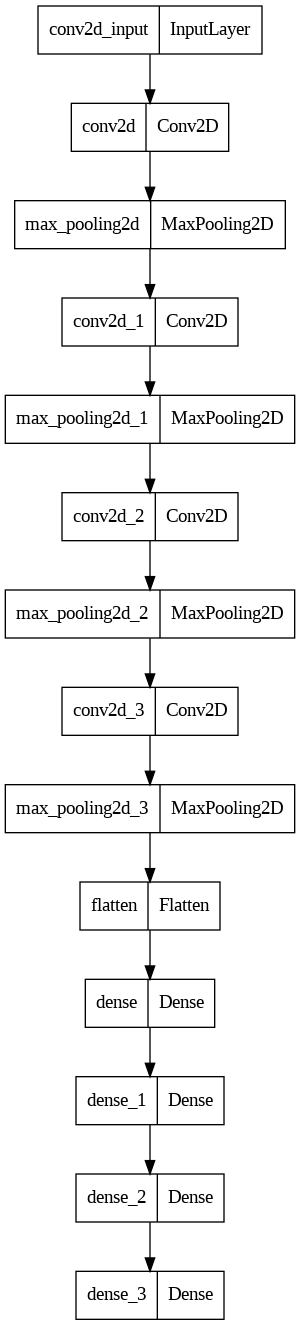

In [19]:
plot_model(model)

In [20]:
# use early stopping -> if 0.01 > accuracy increase after one epoch , model will stop to fit
es = EarlyStopping(monitor = 'val_acc', patience = 2, min_delta = 0.01)

In [57]:
# fit our model
history = model.fit_generator(train_data, epochs = 10, verbose = 1, validation_data = validation_data, callbacks = [es])

<ipython-input-57-34458e9b5fd9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data, epochs = 10, verbose = 1, validation_data = validation_data, callbacks = [es])


Epoch 1/10
141/141 [==============================] - 108s 768ms/step - loss: 0.0440 - acc: 0.9876 - val_loss: 0.0659 - val_acc: 0.9811
Epoch 2/10
141/141 [==============================] - 102s 723ms/step - loss: 0.0201 - acc: 0.9936 - val_loss: 0.0512 - val_acc: 0.9860
Epoch 3/10
141/141 [==============================] - 105s 745ms/step - loss: 0.0115 - acc: 0.9965 - val_loss: 0.0495 - val_acc: 0.9880


### Plotting the Model accuracy and Losses

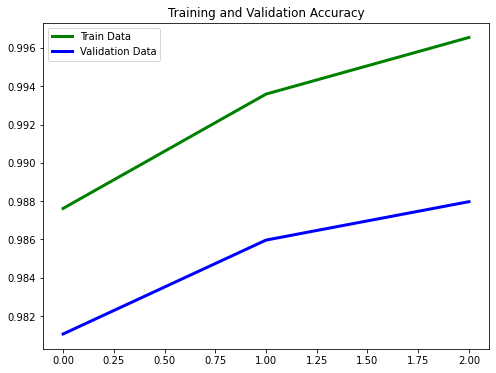

In [70]:
fig = plt.figure(figsize = (8, 6))
plt.plot(history.history['acc'], color = 'green', label = 'Train Data', linewidth = 3)
plt.plot(history.history['val_acc'], color = 'blue', label = 'Validation Data',linewidth = 3)
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

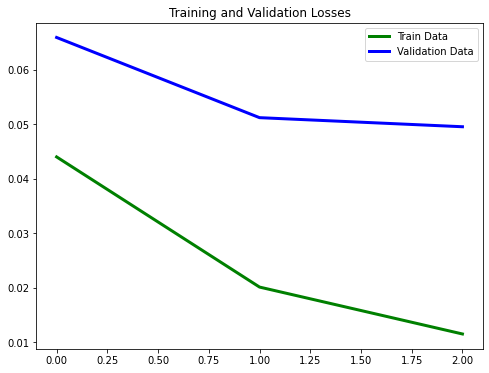

In [71]:
fig = plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], color = 'green', label = 'Train Data',linewidth = 3)
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation Data',linewidth = 3)
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

## Save Model

In [72]:
model_name = "Distracted_Driver_Detection.f5"

In [28]:
# save model in driver, first we need to run this code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
model.save('/content/drive/MyDrive/Colab Notebooks/'+model_name)

### Predict test data

Create Test data

In [31]:
test_data_gen = ImageDataGenerator(rescale = 1./225)

test_data = test_data_gen.flow_from_directory(test_directory,
                          target_size = (224, 224),
                          classes = ['test'],
                          shuffle = False,
                          batch_size = 128)

Found 79726 images belonging to 1 classes.


In [32]:
predict = model.predict(test_data)

623/623 [==============================] - 371s 595ms/step
